In this case we will try to run more epochs in this model hoping that we could get a better result using this model.

In [1]:
#@title Configuration of the variables notebook
model_name = 'roberta-base' #@param
value_batch_size =16 #@param
value_learning_rate = 2.057626963810742e-06 #@param
value_warmup = 0.2410014240231825 #@param
value_w_decay = 8.747541196471078e-09 #@param
value_n_epochs = 4  #@param
value_dropout = 0.3789390401864389 #@param
value_n_labels = 6 #@param

config_models ={
    "model_name": model_name,
    "n_labels": value_n_labels,
    "batch_size": value_batch_size,
    "lr": value_learning_rate,
    "warmup": value_warmup,
    "train_size": None,
    "w_decay": value_w_decay,
    "n_epochs": value_n_epochs,
    "dropout_vals": value_dropout
}

# Preparation for the model

In [2]:
%%capture
!pip install pytorch_lightning optuna

In [3]:
#@title Importing the modules
from google.colab import drive
import os
import torch
drive.mount('/content/drive')

enable_code_paths = True
enable_block = False

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"
    URL_synthetic_data = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/synthetic_data.csv"
    URL_path_save = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
    URL_helper ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/helper/"
    URL_hyperparameters ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/hyperparameters/"
    URL_test_labels ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/test_labels.csv"
    URL_test ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/test.csv"
    URL_model_saved_015 ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/015_model"
    URL_model_saved_017 ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/017_model"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"
    URL_helper = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
import sys
sys.path.append(URL_helper)

from colab_helper import proportion_balance_classes

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
num_workers_colab = num_cores - 1
print(f'Setting num_workers to: {num_workers_colab}')

num_gpus_colab = torch.cuda.device_count()
gpu_list = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
num_gpus_colab, gpu_list


"""
import the modules and configuration colors
"""
## Core Libraries
import os
import time
import math
import numpy as np
import pandas as pd

# Sklearn for Evaluation Metrics and Model Selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (
    accuracy_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# PyTorch Libraries and Lightning
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import pytorch_lightning as pl

# Hugging Face Transformers
from transformers import (
    AutoTokenizer, AutoModel,
    get_linear_schedule_with_warmup
)

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Progress Bar
from tqdm import tqdm

# Hyperparameter Tuning
import optuna
import joblib

# Google Colab (if applicable)
from google.colab import drive

# TorchMetrics (for AUROC calculation)
from torchmetrics.functional.classification import auroc

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

"""
Colorama
"""
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

Mounted at /content/drive
Number of available CPU cores: 8
Setting num_workers to: 7


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

We will be exploring the Roberta model and see if we could find any good performance

In [4]:
#@title Preprocesing the dataset
dataframe = pd.read_csv(URL_path)
dataframe_test_import = pd.read_csv(URL_test)
dataframe_test_labels = pd.read_csv(URL_test_labels)
print(dataframe.head())

"""
Test dataset preparation
"""
attributes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
new_attributes = attributes + ["non_toxic"]

dataframe_test_labels_filtered = dataframe_test_labels.loc[dataframe_test_labels[attributes].sum(axis=1) >= 0]
dataframe_test_labels_filtered.shape
dataframe_test = dataframe_test_labels_filtered.merge(dataframe_test_import, on='id')
dataframe_test = dataframe_test.drop(columns=["id"])

SAMPLE_PERCENTAGE_TEST = 1 #@param
dataframe_test=dataframe_test.sample(frac=SAMPLE_PERCENTAGE_TEST,random_state=42)

print(dataframe_test.shape)
print("dataframe_test")
print(dataframe_test.head())

# Use the attributes list in the condition
dataframe["non_toxic"] = np.where(dataframe[attributes].any(axis=1), 0, 1)
dataframe.head()

                                        comment_text  toxic  severe_toxic  \
0  ExplanationWhy the edits made under my usernam...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "MoreI can't make any real suggestions on impr...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0  
(63978, 7)
dataframe_test
       toxic  severe_toxic  obscene  threat  insult  identity_hate  \
51138      1             0        0       0       0              0   
40102      0             0        0       0       0              0   
144        0             0        0  

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Now we will split the dataset to understand whats happening

In [5]:
#@title Split the dataset
# drop the non toxic column
dataframe.drop(columns= ["non_toxic"], inplace= True)

# sample sisze
SAMPLE_PERCENTAGE = 1 #@param
dataframe_clean=dataframe.sample(frac=SAMPLE_PERCENTAGE,random_state=42)

# split
train_size = 0.8 #@param
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
validation_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(validation_dataset.shape))



FULL Dataset: (144790, 7)
TRAIN Dataset: (115832, 7)
TEST Dataset: (28958, 7)


In [6]:
#@title Add syntetic data and resampling
dataframe_syn = pd.read_csv(URL_synthetic_data)
# dataframe_syn = dataframe_syn.rename(columns={'comment_text': 'text'})
dataframe_syn = dataframe_syn.rename(columns={'text': 'comment_text'})
train_dataset_syn = pd.concat([train_dataset, dataframe_syn]).reset_index(drop=True)
print(train_dataset_syn.shape)
train_dataset_syn.head()

(119332, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Easier than I thought; it's 90% copyvio. Page...,0,0,0,0,0,0
1,"""Good question, and yes that is what it is abo...",0,0,0,0,0,0
2,Your source says 130 thousand years old but th...,0,0,0,0,0,0
3,Who makes personel attacks? This users always ...,0,0,0,0,0,0
4,Fresh start? The article seemed like a good su...,0,0,0,0,0,0


The data created sinteticaly was creating a gpt so what we do its join some repeated words with some sentences to see if it works fine.

We will now reduce the size of the training dataset to achieve better balance. Specifically, we will reduce the number of non-toxic examples by half to create a more balanced dataset.

In [7]:
def reduce_size_data_train(dataset:pd.DataFrame, sample_name: str)->pd.DataFrame:
    """ reduce the size of the dataset """
    target_y =dataset.iloc[:,1:].sum()
    attributes_non_toxic = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    non_toxic = dataset.loc[dataset[attributes_non_toxic].sum(axis=1) == 0]
    toxic = dataset.loc[dataset[attributes_non_toxic].sum(axis=1) > 0]
    non_toxic = non_toxic.sample(n=target_y["toxic"], random_state=7)
    dataset = pd.concat([toxic,non_toxic]).reset_index(drop=True)
    print(f"samples for {sample_name}: {dataset.shape}")

    return dataset

train_dataset = reduce_size_data_train(train_dataset, "train_dataset")
train_dataset_syn = reduce_size_data_train(train_dataset_syn, "train_dataset")

def normalize_values(dataset:pd.DataFrame)-> torch.tensor:
    target_y = dataset.iloc[:,1:].sum()
    weights_list = target_y.tolist()
    weights = torch.tensor(weights_list, dtype=torch.float32)
    normalized_weights = weights / weights.sum()
    print(normalized_weights)

    return normalized_weights

normalized_weights = normalize_values(train_dataset)
normalized_weights_syn = normalize_values(train_dataset_syn)

samples for train_dataset: (23857, 7)
samples for train_dataset: (27357, 7)
tensor([0.4361, 0.0428, 0.2414, 0.0141, 0.2248, 0.0409])
tensor([0.3853, 0.0876, 0.2133, 0.0457, 0.1986, 0.0694])


We reduced the dataset size from 100k to 26k, removing a significant number of rows. This reduction allows the model to improve both in terms of training time and performance.

# Create a dataset

We will be preparing the dataset for the importation!

In [8]:
#@title custom dataset import class
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, comment_str_title: str,  tokenizer, attributes, max_token_len= 128, sample= None):

        assert isinstance(dataframe, pd.DataFrame), "dataframe needs to be a pandas DataFrame for this code to work"

        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.attributes = attributes
        self.sample = sample
        self._prepare_data()

        # column to select
        self.comment_str_title = comment_str_title

    def _prepare_data(self):
        """Prepare the data and imported"""
        # data = pd.read_csv(self.data_path)
        data = self.dataframe.copy()
        # add the non toxic column
        data["non_toxic"] = np.where(data[attributes].any(axis=1), 0, 1)
        # data["unhealthy"] = np.where(data["healthy"] == 1, 0, 1)

        # extract the sample with some attributes
        if self.sample is not None:
            toxic = data.loc[data[self.attributes].sum(axis=1) > 0]
            non_toxic = data.loc[data[self.attributes].sum(axis=1) == 0]
            # extract the sample from the healthy values
            non_toxic = non_toxic.sample(min(self.sample, len(non_toxic)), random_state=7)
            self.data = pd.concat([non_toxic, toxic])
        else:
            self.data = data

    def __len__(self):
        """Length of the dataset"""
        return (len(self.data))

    def __getitem__(self, index):
        """Get item from the dataset"""
        data_row = self.data.iloc[index]

        # item as a string
        comment = str(data_row[self.comment_str_title])
        # attributes_numbers = torch.FloatTensor(data_row.iloc[self.attributes])
        attributes_numbers = torch.FloatTensor(data_row[self.attributes].values.astype(float))

        # extract the tokens and prepared to apply it to the comment line
        tokens = self.tokenizer.encode_plus(
                    comment,
                    add_special_tokens = True,
                    max_length = self.max_token_len,
                    padding = 'max_length',
                    truncation = True, # cap the comments to a max length of tokens
                    return_tensors = 'pt', # return tensors
                    return_attention_mask = True,
                    return_token_type_ids = False, # this its not need it
                    )

        return {'input_id': tokens.input_ids.flatten(),
                'attention_mask': tokens.attention_mask.flatten(),
                'labels': attributes_numbers,
                'labels_names': self.attributes}


# Data loader

In [9]:
#@title Custom class data loader
class Data_loader_Custom(pl.LightningDataModule):
    def __init__(self, train_dataframe, val_dataframe , attributes, comment_str_title: str, tokenizer,model_name = 'roberta-base',   batch_size= 16, max_token_len= 128 , sample= None, num_workers= 4, prediction_count = False):
        super().__init__()
        self.train_dataframe = train_dataframe
        self.val_dataframe = val_dataframe
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.comment_str_title = comment_str_title
        self.attributes = attributes
        self.sample = sample
        self.num_workers = num_workers
        self.tokenizer = tokenizer
        self.model_name = model_name
        self.prediction_count = prediction_count

        # check if exist
        self.has_train_data = train_dataframe is not None
        self.has_val_data = val_dataframe is not None

    def __len__(self):
        if self.has_train_data:
            return len(self.train_dataset)
        if self.has_val_data:
            return len(self.validation_dataset)

    def len_predictions(self):
        if self.has_val_data:
            return len(self.validation_dataset)

    # this its using the LightningDataModule for seting up
    def setup(self, stage= None):
        if stage in (None, 'fit'):
            # train set
            self.train_dataset = CustomDataset(
                                dataframe=  self.train_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)
            # validation set
            self.validation_dataset = CustomDataset(
                                dataframe=  self.val_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)
        if stage == 'predict':
            self.predict_dataset  = CustomDataset(
                                dataframe=  self.val_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)

    # dataload the the different sets
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=  self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, num_workers= self.num_workers, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.batch_size, num_workers= self.num_workers, shuffle=False)


----------

# Load the models

In [10]:
#@title preparing the architecture of the 2 models
class Classifier_model_loader(nn.Module):
    def __init__(self, config: dict, loss_function=None):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config["n_labels"])
        self.dropout = nn.Dropout(config["dropout_vals"])

        # Use provided loss function, or default to BCEWithLogitsLoss
        if loss_function is None:
            self.loss_function = nn.BCEWithLogitsLoss(reduction='mean')
        else:
            self.loss_function = loss_function

    def forward(self, input_ids, attention_mask):
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_out = torch.mean(output.last_hidden_state, 1)
        pooled_output = self.hidden(pooled_out)
        pooled_output = self.dropout(pooled_output)
        pooled_output = torch.relu(pooled_output)
        logits = self.classification(pooled_output)

        return logits

    def compute_loss(self, predictions, targets):
        return self.loss_function(predictions, targets)


# Initialize the model with the same configuration
roberta_015 = Classifier_model_loader(config_models,
                                       loss_function=nn.BCEWithLogitsLoss(weight=normalized_weights))
roberta_017_syn = Classifier_model_loader(config_models,
                                       loss_function=nn.BCEWithLogitsLoss(weight=normalized_weights_syn))

# Move both models to the appropriate device
roberta_015 = roberta_015.to(device)
roberta_017_syn = roberta_017_syn.to(device)

# Load the state dict (this includes pretrained weights and custom layers)
roberta_015.load_state_dict(torch.load(os.path.join(URL_model_saved_015, "model_015.pth")))
roberta_017_syn.load_state_dict(torch.load(os.path.join(URL_model_saved_017, "model_017.pth")))

print("Model loaded successfully!")
print("-------------------------")
print(roberta_015)
print("-------------------------")
print(roberta_017_syn)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-09dcdb0d6c33>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default val

Model loaded successfully!
-------------------------
Classifier_model_loader(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in

# Predict the model
We have two models, 015 and 017, where we will experiment with varying thresholds to understand how adjusting them can help filter values effectively. By setting different thresholds for each category, we aim to optimize the results and achieve better performance.

In [11]:
#@title predictibility model
def classify_raw_comments(model, dataset_loader_class):
    model.eval()
    all_predictions = []
    for batch in dataset_loader_class.predict_dataloader():
        input_ids = batch['input_id'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Make the prediction
        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Sigmoid activation for multi-label classification
        batch_predictions = torch.sigmoid(outputs).cpu().numpy()  # Move back to CPU if using GPU
        all_predictions.extend(batch_predictions)

    # Stack all predictions into a numpy array
    flatten_predictions = np.stack(all_predictions)
    print(flatten_predictions.shape)
    print(len(all_predictions))
    return flatten_predictions

"""
create data loaders
"""
validation_dataloader = Data_loader_Custom(
                   train_dataframe = train_dataset,
                   val_dataframe = validation_dataset,
                   attributes = attributes,
                   comment_str_title = 'comment_text',
                   tokenizer = AutoTokenizer.from_pretrained(config_models["model_name"]),
                   batch_size= config_models["batch_size"],
                   max_token_len= 256 ,
                   sample= None,
                   num_workers= num_workers_colab,
                   prediction_count= False)

test_dataloader = Data_loader_Custom(
                   train_dataframe = train_dataset,
                   val_dataframe = dataframe_test,
                   attributes = attributes,
                   comment_str_title = 'comment_text',
                   tokenizer = AutoTokenizer.from_pretrained(config_models["model_name"]),
                   batch_size= config_models["batch_size"],
                   max_token_len= 256 ,
                   sample= None,
                   num_workers= num_workers_colab,
                   prediction_count= False)




tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Roberta model 015

(28958, 6)
28958
(28958, 6)
28958


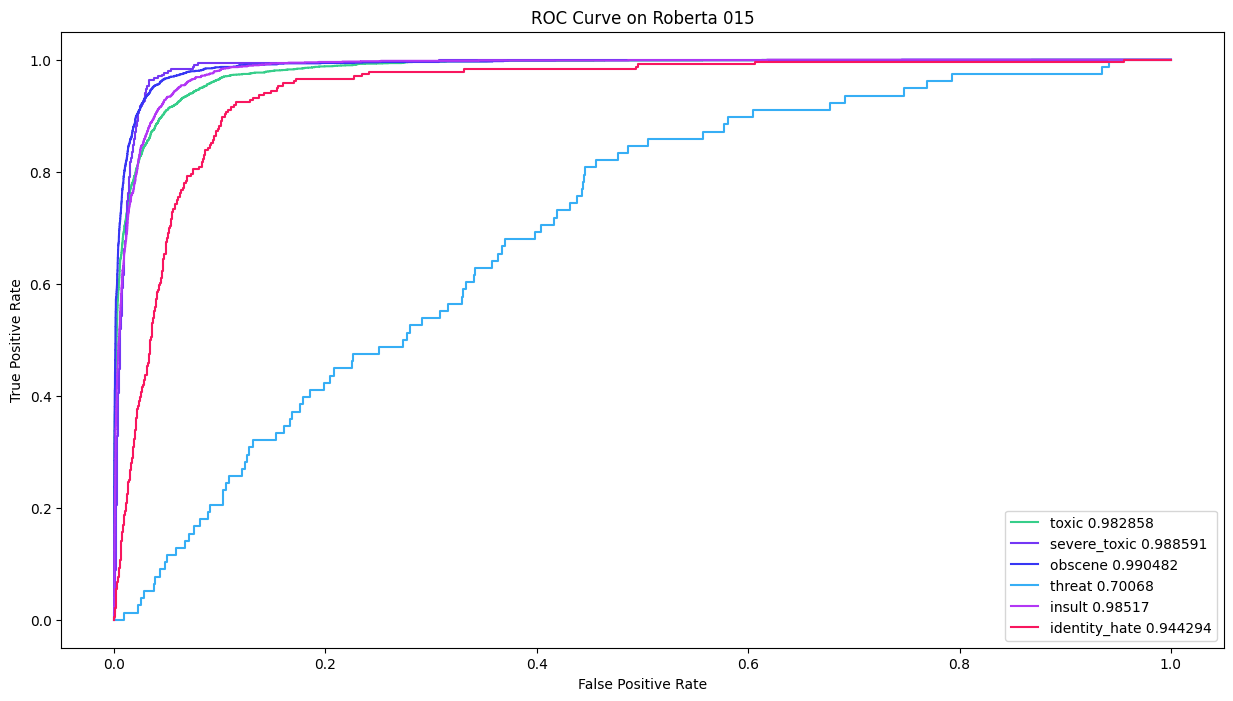

In [12]:
"""
model 015
"""
validation_dataloader.setup(stage='predict')
predictions_object_val_15 = classify_raw_comments(roberta_015, validation_dataloader)
print(predictions_object_val_15.shape)

true_labels_val_15 = np.array(validation_dataset[attributes].values)
print(len(true_labels_val_15))


plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels_val_15[:, i].astype(int), predictions_object_val_15[:, i])
    auc = metrics.roc_auc_score(true_labels_val_15[:, i].astype(int), predictions_object_val_15[:, i])
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta 015')
plt.legend(loc = "lower right")
plt.show()

When analyzing the model's performance, it appears that the "threat" category is not being predicted accurately in the validation dataset. However, the other categories seem to perform well, indicating that the issue might be specific to this category rather than a broader problem with the model.

(63978, 6)
63978
(63978, 6)
63978


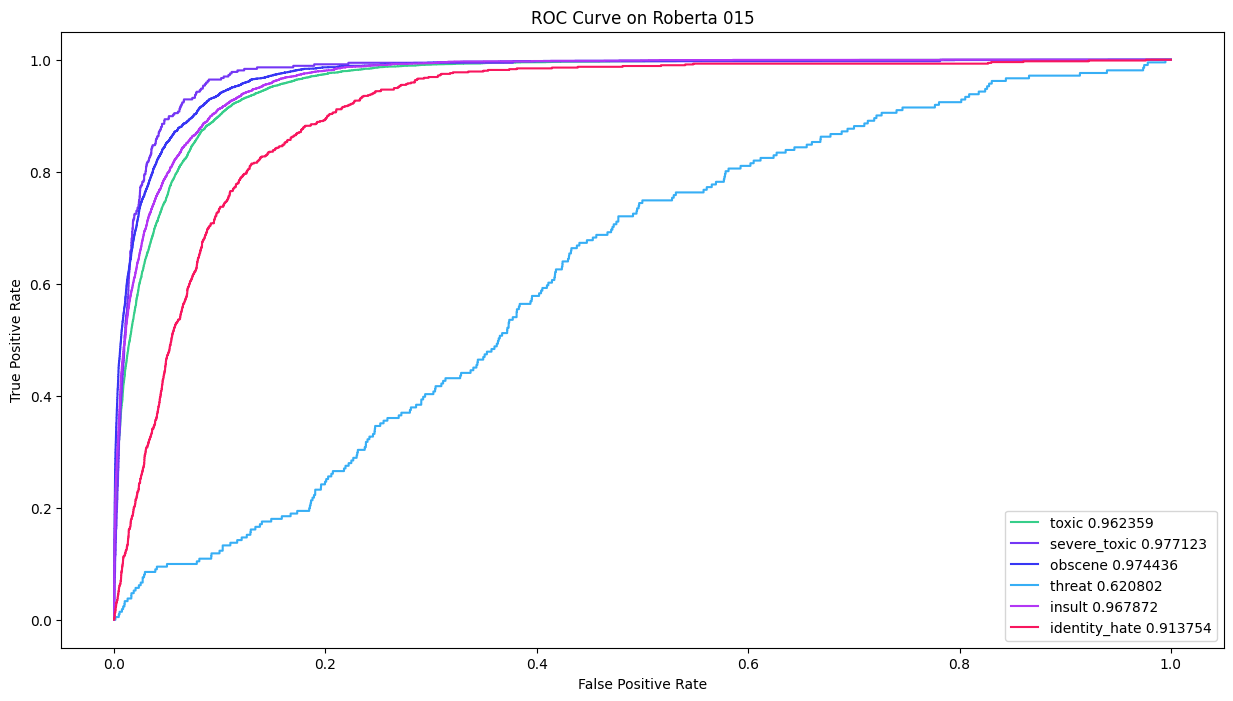

In [13]:
"""
model 015
"""
test_dataloader.setup(stage='predict')
predictions_object_test_15 = classify_raw_comments(roberta_015, test_dataloader)
print(predictions_object_test_15.shape)

true_labels_test_15 = np.array(dataframe_test[attributes].values)
print(len(true_labels_test_15))

plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels_test_15[:, i].astype(int), predictions_object_test_15[:, i])
    auc = metrics.roc_auc_score(true_labels_test_15[:, i].astype(int), predictions_object_test_15[:, i])
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta 015')
plt.legend(loc = "lower right")
plt.show()


The model is effective in predicting these categories, with a good balance between true positive rate (sensitivity) and false positive rate. The threat category has a significantly lower AUC score (0.620802), showing that the model struggles with distinguishing threat labels.

### Roberta model 017 syntetic

(28958, 6)
28958
(28958, 6)
28958


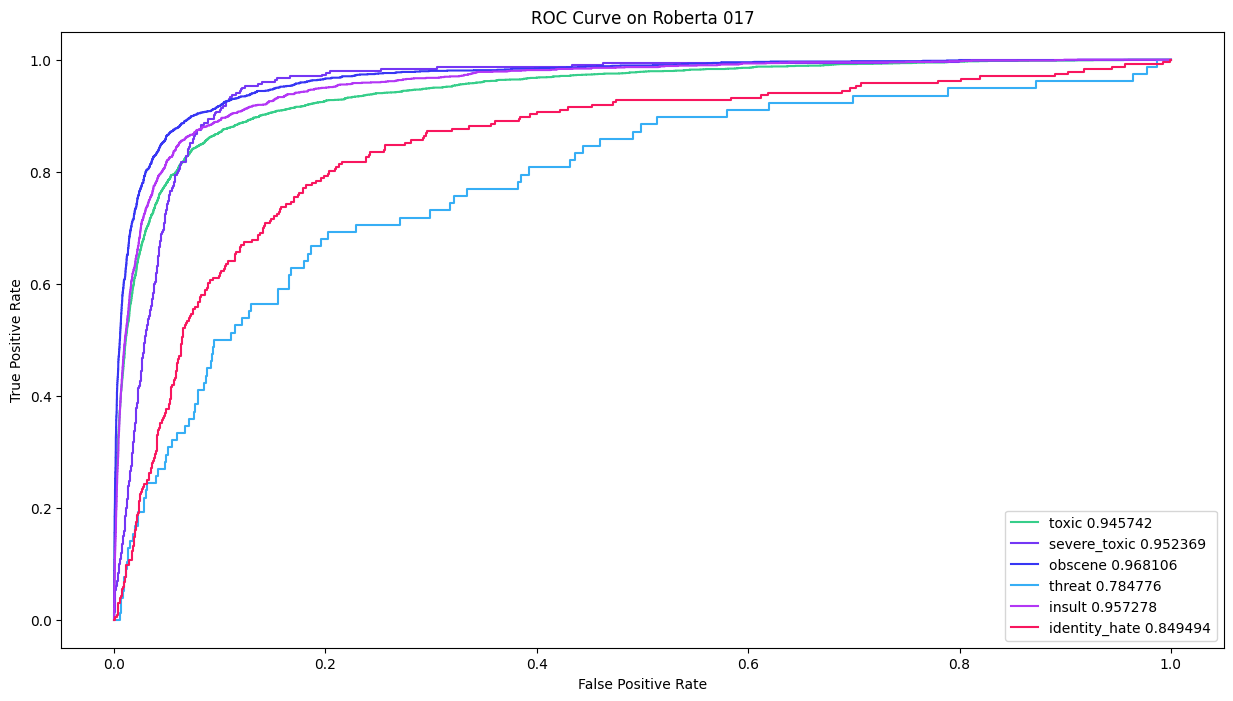

In [14]:
"""
model 017
"""
validation_dataloader.setup(stage='predict')
predictions_object_val_17 = classify_raw_comments(roberta_017_syn, validation_dataloader)
print(predictions_object_val_17.shape)

true_labels_val_17 = np.array(validation_dataset[attributes].values)
print(len(true_labels_val_17))


plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels_val_17[:, i].astype(int), predictions_object_val_17[:, i])
    auc = metrics.roc_auc_score(true_labels_val_17[:, i].astype(int), predictions_object_val_17[:, i])
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta 017')
plt.legend(loc = "lower right")
plt.show()

We can observe that while categories like *treat* perform well, the *threat* category is performing comparatively worse overall.

(63978, 6)
63978
(63978, 6)
63978


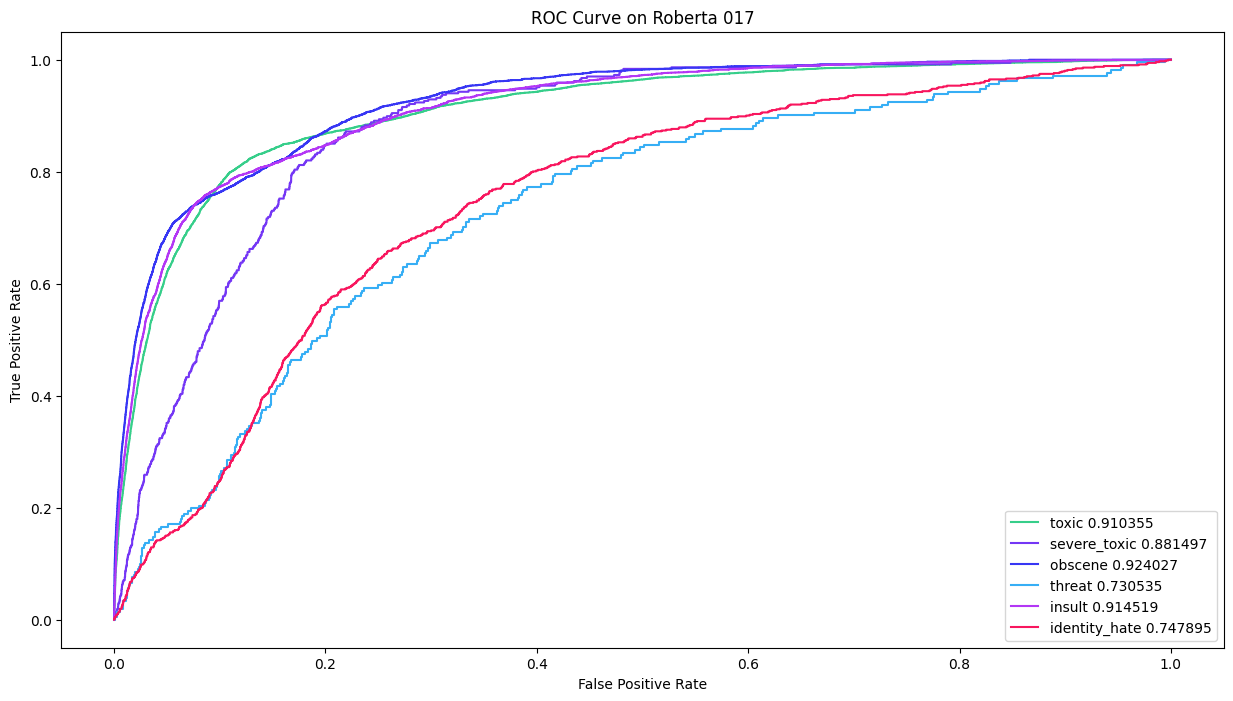

In [15]:
"""
model 017
"""
test_dataloader.setup(stage='predict')
predictions_object_test_17 = classify_raw_comments(roberta_017_syn, test_dataloader)
print(predictions_object_test_17.shape)

true_labels_test_17 = np.array(dataframe_test[attributes].values)
print(len(true_labels_test_17))

plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels_test_17[:, i].astype(int), predictions_object_test_17[:, i])
    auc = metrics.roc_auc_score(true_labels_test_17[:, i].astype(int), predictions_object_test_17[:, i])
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta 017')
plt.legend(loc = "lower right")
plt.show()

n this case, the model appears to perform better on the threat class, but its performance is weaker on identity hate and severe toxic.

## Review confusion matrix for the thresholds

In [16]:
def threshold_calculation(predictions_object, true_labels, thresholds_values):
    confusion_matrices_per_threshold = []

    for threshold in thresholds_values:

        predictions_binary = (predictions_object >= threshold).astype(int)
        confusion_matrices = []
        num_classes = true_labels.shape[1]
        for i in range(num_classes):
            true_class = true_labels[:, i]
            pred_class = predictions_binary[:, i]
            cm = confusion_matrix(true_class, pred_class)
            confusion_matrices.append(cm)

        # Append results for this threshold
        confusion_matrices_per_threshold.append({
            "threshold": threshold,
            "confusion_matrices": confusion_matrices
        })

    # Print confusion matrices for each threshold and class
    for result in confusion_matrices_per_threshold:
        print(f"========================")
        print(f"Threshold: {result['threshold']:.2f}")
        for i, cm in enumerate(result["confusion_matrices"]):
            attribute_name = attributes[i]
            print(f"Confusion matrix for class {attribute_name}:")
            print(cm)
            print()
        print(f"========================")

thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_calculation(predictions_object_val_15, true_labels_val_15, thresholds_values)

Threshold: 0.10
Confusion matrix for class toxic:
[[21341  4785]
 [   41  2791]]

Confusion matrix for class severe_toxic:
[[27579  1077]
 [   11   291]]

Confusion matrix for class obscene:
[[25811  1589]
 [   45  1513]]

Confusion matrix for class threat:
[[20580  8300]
 [   37    41]]

Confusion matrix for class insult:
[[25401  2043]
 [   53  1461]]

Confusion matrix for class identity_hate:
[[26996  1726]
 [   59   177]]

Threshold: 0.20
Confusion matrix for class toxic:
[[22817  3309]
 [   72  2760]]

Confusion matrix for class severe_toxic:
[[28400   256]
 [  115   187]]

Confusion matrix for class obscene:
[[26515   885]
 [   97  1461]]

Confusion matrix for class threat:
[[28168   712]
 [   76     2]]

Confusion matrix for class insult:
[[26233  1211]
 [  126  1388]]

Confusion matrix for class identity_hate:
[[28668    54]
 [  226    10]]

Threshold: 0.30
Confusion matrix for class toxic:
[[23587  2539]
 [  102  2730]]

Confusion matrix for class severe_toxic:
[[28601    55]


In [18]:
thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_calculation(predictions_object_val_17, true_labels_val_17, thresholds_values )

Threshold: 0.10
Confusion matrix for class toxic:
[[14219 11907]
 [   73  2759]]

Confusion matrix for class severe_toxic:
[[19479  9177]
 [    4   298]]

Confusion matrix for class obscene:
[[21202  6198]
 [   45  1513]]

Confusion matrix for class threat:
[[19670  9210]
 [   20    58]]

Confusion matrix for class insult:
[[20942  6502]
 [   62  1452]]

Confusion matrix for class identity_hate:
[[23524  5198]
 [   54   182]]

Threshold: 0.20
Confusion matrix for class toxic:
[[19261  6865]
 [  165  2667]]

Confusion matrix for class severe_toxic:
[[27771   885]
 [  146   156]]

Confusion matrix for class obscene:
[[24346  3054]
 [  110  1448]]

Confusion matrix for class threat:
[[27170  1710]
 [   53    25]]

Confusion matrix for class insult:
[[24862  2582]
 [  171  1343]]

Confusion matrix for class identity_hate:
[[27677  1045]
 [  170    66]]

Threshold: 0.30
Confusion matrix for class toxic:
[[21788  4338]
 [  247  2585]]

Confusion matrix for class severe_toxic:
[[28649     7]


It appears that for categories like severe_toxic, threat, and identity_hate, we will set a threshold of 10, hoping to improve the results. For the other categories, we may experiment with a 40% threshold to see how it performs, as this seems to yield more accurate predictions with fewer false positives.

In [22]:

def threshold_classification_report(predictions_object, true_labels, thresholds_values):
    """
    Evaluate predictions across multiple thresholds in a classification report
    """
    # Loop through each threshold
    for threshold in thresholds_values:
        print("=" * 50)
        print(f"Threshold: {threshold:.2f}")
        print("=" * 50)

        # Apply threshold to predictions
        predicted_labels = (predictions_object >= threshold).astype(int)

        # Compute confusion matrix and classification report for all classes
        conf_matrix = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())

        print("Confusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels, target_names=[f"{i}" for i in attributes]))
        print("-" * 50)
        print("\n")



thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_classification_report(predictions_object_val_15, true_labels_val_15, thresholds_values )

Threshold: 0.10
Confusion Matrix:
[[147708  19520]
 [   246   6274]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.37      0.99      0.54      2832
 severe_toxic       0.21      0.96      0.35       302
      obscene       0.49      0.97      0.65      1558
       threat       0.00      0.53      0.01        78
       insult       0.42      0.96      0.58      1514
identity_hate       0.09      0.75      0.17       236

    micro avg       0.24      0.96      0.39      6520
    macro avg       0.26      0.86      0.38      6520
 weighted avg       0.39      0.96      0.55      6520
  samples avg       0.05      0.10      0.06      6520

--------------------------------------------------


Threshold: 0.20
Confusion Matrix:
[[160801   6427]
 [   712   5808]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.45      0.97      0.62      2832
 severe_toxic       0.42      0.62      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

               precision    recall  f1-score   support

        toxic       0.57      0.94      0.71      2832
 severe_toxic       0.50      0.00      0.01       302
      obscene       0.76      0.86      0.81      1558
       threat       0.00      0.00      0.00        78
       insult       0.69      0.78      0.73      1514
identity_hate       0.00      0.00      0.00       236

    micro avg       0.63      0.80      0.71      6520
    macro avg       0.42      0.43      0.38      6520
 weighted avg       0.61      0.80      0.67      6520
  samples avg       0.08      0.08      0.08      6520

--------------------------------------------------


Threshold: 0.50
Confusion Matrix:
[[164974   2254]
 [  1542   4978]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.62      0.93      0.74      2832
 severe_toxic       0.00      0.00      0.00       302
      obscene       0.81      0.81      0.81      1558
       threat       0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

               precision    recall  f1-score   support

        toxic       0.82      0.79      0.80      2832
 severe_toxic       0.00      0.00      0.00       302
      obscene       0.93      0.60      0.73      1558
       threat       0.00      0.00      0.00        78
       insult       0.91      0.36      0.52      1514
identity_hate       0.00      0.00      0.00       236

    micro avg       0.86      0.57      0.68      6520
    macro avg       0.44      0.29      0.34      6520
 weighted avg       0.79      0.57      0.64      6520
  samples avg       0.08      0.06      0.06      6520

--------------------------------------------------


Threshold: 0.90
Confusion Matrix:
[[167020    208]
 [  3848   2672]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.65      0.76      2832
 severe_toxic       0.00      0.00      0.00       302
      obscene       0.97      0.41      0.58      1558
       threat       0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_classification_report(predictions_object_val_17, true_labels_val_17, thresholds_values )

Threshold: 0.10
Confusion Matrix:
[[119036  48192]
 [   258   6262]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.19      0.97      0.32      2832
 severe_toxic       0.03      0.99      0.06       302
      obscene       0.20      0.97      0.33      1558
       threat       0.01      0.74      0.01        78
       insult       0.18      0.96      0.31      1514
identity_hate       0.03      0.77      0.06       236

    micro avg       0.11      0.96      0.21      6520
    macro avg       0.11      0.90      0.18      6520
 weighted avg       0.17      0.96      0.29      6520
  samples avg       0.05      0.10      0.06      6520

--------------------------------------------------


Threshold: 0.20
Confusion Matrix:
[[151087  16141]
 [   815   5705]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.28      0.94      0.43      2832
 severe_toxic       0.15      0.52      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

Confusion Matrix:
[[162728   4500]
 [  1731   4789]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.47      0.88      0.61      2832
 severe_toxic       0.00      0.00      0.00       302
      obscene       0.59      0.80      0.68      1558
       threat       0.00      0.00      0.00        78
       insult       0.61      0.69      0.65      1514
identity_hate       0.00      0.00      0.00       236

    micro avg       0.52      0.73      0.61      6520
    macro avg       0.28      0.40      0.32      6520
 weighted avg       0.49      0.73      0.58      6520
  samples avg       0.08      0.08      0.07      6520

--------------------------------------------------


Threshold: 0.50
Confusion Matrix:
[[164535   2693]
 [  2290   4230]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.56      0.83      0.67      2832
 severe_toxic       0.00      0.00      0.00       302
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Confusion Matrix:
[[166773    455]
 [  4784   1736]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.79      0.59      0.67      2832
 severe_toxic       0.00      0.00      0.00       302
      obscene       0.99      0.05      0.09      1558
       threat       0.00      0.00      0.00        78
       insult       0.00      0.00      0.00      1514
identity_hate       0.00      0.00      0.00       236

    micro avg       0.79      0.27      0.40      6520
    macro avg       0.30      0.11      0.13      6520
 weighted avg       0.58      0.27      0.31      6520
  samples avg       0.06      0.03      0.04      6520

--------------------------------------------------


Threshold: 0.90
Confusion Matrix:
[[167141     87]
 [  5665    855]]

Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.30      0.45      2832
 severe_toxic       0.00      0.00      0.00       302
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In this case, we will confirm our previous analysis by sticking with 10% and 40% thresholds for predictability, depending on the specific situation.

#binary verification

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def threshold_classification_report_binary(predictions_object, true_labels, thresholds_values):
    """
    Evaluate predictions across multiple thresholds for binary classification.
    Combines all toxic categories into a single 'toxic' label.

    Parameters:
    - predictions_object: np.ndarray, predicted probabilities for each label
    - true_labels: np.ndarray, true binary labels (0s and 1s for each class)
    - thresholds_values: list or np.ndarray, thresholds to evaluate
    """
    # Combine all categories into a binary toxic/non-toxic label
    true_labels_binary = (true_labels.sum(axis=1) > 0).astype(int)  # Toxic if any class is 1
    print(f"True labels (binary): {np.unique(true_labels_binary, return_counts=True)}")

    # Loop through each threshold
    for threshold in thresholds_values:
        print("=" * 50)
        print(f"Threshold: {threshold:.2f}")
        print("=" * 50)

        # Apply threshold to predictions and combine into a binary label
        predicted_labels_binary = (predictions_object >= threshold).astype(int).sum(axis=1) > 0
        conf_matrix = confusion_matrix(true_labels_binary, predicted_labels_binary)

        print("Confusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(classification_report(true_labels_binary, predicted_labels_binary, target_names=["Non-Toxic", "Toxic"]))
        print("-" * 50)
        print("\n")


thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_classification_report_binary(predictions_object_val_15, true_labels_val_15, thresholds_values)


True labels (binary): (array([0, 1]), array([25957,  3001]))
Threshold: 0.10
Confusion Matrix:
[[16955  9002]
 [   35  2966]]

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.65      0.79     25957
       Toxic       0.25      0.99      0.40      3001

    accuracy                           0.69     28958
   macro avg       0.62      0.82      0.59     28958
weighted avg       0.92      0.69      0.75     28958

--------------------------------------------------


Threshold: 0.20
Confusion Matrix:
[[22371  3586]
 [   79  2922]]

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.86      0.92     25957
       Toxic       0.45      0.97      0.61      3001

    accuracy                           0.87     28958
   macro avg       0.72      0.92      0.77     28958
weighted avg       0.94      0.87      0.89     28958

--------------------------------------------------


T

In this case, we will stick with 60% precision and 94% recall when using the 40% threshold, but we will adjust the threshold based on our specific goals.

In [26]:

thresholds_values = np.linspace(0.1, 0.9, 9)
threshold_classification_report_binary(predictions_object_val_17, true_labels_val_17, thresholds_values)

True labels (binary): (array([0, 1]), array([25957,  3001]))
Threshold: 0.10
Confusion Matrix:
[[10743 15214]
 [   60  2941]]

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.99      0.41      0.58     25957
       Toxic       0.16      0.98      0.28      3001

    accuracy                           0.47     28958
   macro avg       0.58      0.70      0.43     28958
weighted avg       0.91      0.47      0.55     28958

--------------------------------------------------


Threshold: 0.20
Confusion Matrix:
[[19116  6841]
 [  174  2827]]

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.99      0.74      0.84     25957
       Toxic       0.29      0.94      0.45      3001

    accuracy                           0.76     28958
   macro avg       0.64      0.84      0.65     28958
weighted avg       0.92      0.76      0.80     28958

--------------------------------------------------


T

In the syntetic data seems that its better the 50% for the therhold in the big classes

### Summary
In summary, we will stick with the 40% threshold for toxic, obscene, and insult categories. For the remaining classes, we will apply a 10% threshold to evaluate how it performs.